In [6]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.cuda.amp import GradScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from tqdm.auto import tqdm
from skimage.metrics import peak_signal_noise_ratio
import torchvision.models as models
from torch.nn.functional import mse_loss
from torch.optim import Adam
from sr_model import FSRCNN
from IPython import display

In [7]:
hr_imgs = torch.load("hr_dataset.pt").cpu()
blur_imgs = torch.load("blur_dataset.pt").cpu()

print(hr_imgs.shape)
print(blur_imgs.shape)

hr_imgs = hr_imgs[:, ...].cuda()
blur_imgs = blur_imgs[:, ...].cuda()

torch.Size([5004, 3, 256, 256])
torch.Size([5004, 3, 128, 128])


In [8]:
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))

torch.cuda.memory_allocated: 4.582275GB


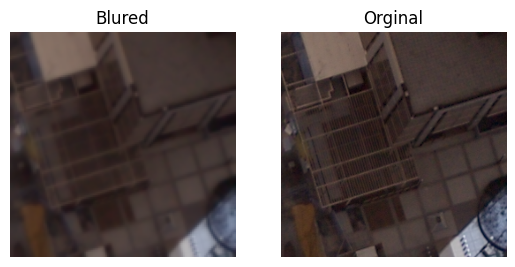

In [9]:
index = 2
plt.figure()
plt.subplot(121)
plt.imshow(blur_imgs[index, ...].permute(1,2,0).cpu().to(torch.float32))
plt.axis('off')
plt.title('Blured')
plt.subplot(122)
plt.imshow(hr_imgs[index, ...].permute(1,2,0).cpu().to(torch.float32))
plt.axis('off')
plt.title('Orginal')
plt.show()

In [10]:
train_valid_dataset = torch.utils.data.dataset.TensorDataset(blur_imgs,hr_imgs)
train_size = int(0.8*len(train_valid_dataset))
test_size = len(train_valid_dataset)-train_size
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(
    train_valid_dataset, [train_size, test_size]
)

Train Dataset length:  4003
Valid Dataset Length:  1001


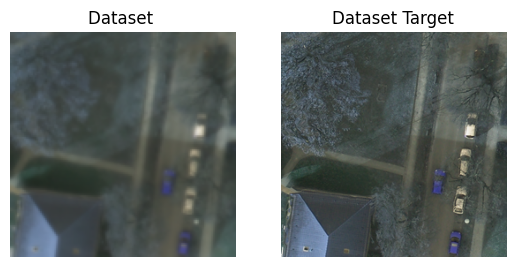

In [11]:
print('Train Dataset length: ', len(train_dataset))
print('Valid Dataset Length: ', len(valid_dataset))

looked_up = 5
plt.figure()
plt.subplot(121)
plt.imshow(valid_dataset.__getitem__(looked_up)[0].permute(1,2,0).cpu().to(torch.float32))
plt.axis('off')
plt.title('Dataset ')
plt.subplot(122)
plt.imshow(valid_dataset.__getitem__(looked_up)[1].permute(1,2,0).cpu().to(torch.float32))
plt.axis('off')
plt.title('Dataset Target')
plt.show()

In [12]:
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

Train Dataset length:  4003
Valid Dataset Length:  1001


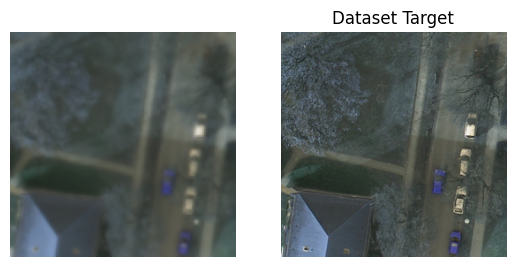

In [13]:
print('Train Dataset length: ', len(train_dataset))
print('Valid Dataset Length: ', len(valid_dataset))

true_np = valid_dataset.__getitem__(looked_up)[1]
blur_np = valid_dataset.__getitem__(looked_up)[0]

looked_up = 20
plt.figure()
plt.subplot(121)
plt.imshow(blur_np.permute(1,2,0).cpu().to(torch.float32))
plt.axis('off')
plt.subplot(122)
plt.imshow(true_np.permute(1,2,0).cpu().to(torch.float32))
plt.axis('off')
plt.title('Dataset Target')
plt.show()

In [14]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=False
)

KeyboardInterrupt: 

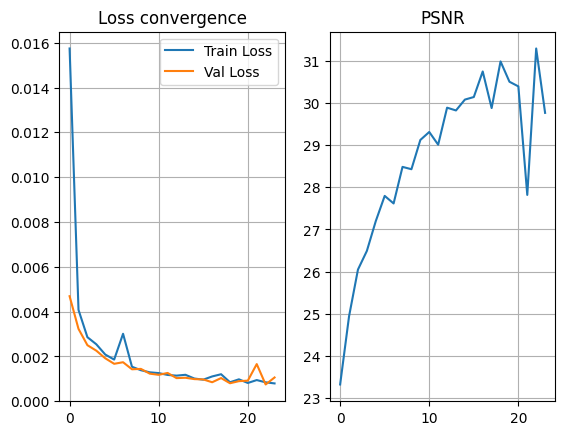

In [15]:
n_epochs = 100
learning_rate = 1e-3
upscale_factor = 2
model = FSRCNN(upscale_factor).cuda()
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameters: ', params)

best_accu = 1e6

loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

scaler = GradScaler()

train_set_len = len(train_loader)
val_set_len = len(valid_loader)
train_loss, val_loss, psnr_loss = [], [], []
plt.figure()

for epoch in tqdm(range(n_epochs), desc='Epoch', disable=False):
    model.train()
    accu = 0.0
    
    for X_, y_ in train_loader:
        # Forward pass
        y_hat = model(X_)
        
        loss = loss_fn(y_hat, y_)
        accu += loss.item()

        # backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        
        scaler.update()
        
    train_loss.append(accu / train_set_len)

    # Validation - no gradient & eval mode
    model.eval()
    accu = 0.0
    accu_psnr = 0.0
    with torch.no_grad():
        for X_, y_ in valid_loader:
            # Forward pass
            y_hat = model(X_)
            loss = loss_fn(y_hat, y_)
            accu += loss.item()
            accu_psnr += psnr(y_,y_hat)
        val_loss.append(accu / val_set_len)
        scheduler.step(accu/val_set_len)
        psnr_loss.append(accu_psnr / val_set_len)
        #print('Current PSNR: ',accu_psnr/val_set_len, 'dB')
        #print('Current val_loss: ', accu/val_set_len)
    if accu/train_set_len < best_accu:
        best_accu = accu/train_set_len
        torch.save(model.state_dict(), 'model.pt')
    plt.clf()
    plt.subplot(121)
    plt.plot(train_loss,label='Train Loss')
    plt.plot(val_loss,label='Val Loss')
    plt.grid()
    plt.legend()
    plt.title('Loss convergence')
    plt.subplot(122)
    plt.plot(psnr_loss)
    plt.grid()
    plt.title('PSNR')
    display.display(plt.gcf())
    display.clear_output(wait=True)